In [ ]:
# !pip install mediapipe

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

## KEYPOINT EXTRACTION

In [2]:
mp

<module 'mediapipe' from 'H:\\PYTHON\\PYTHON SYSTEM FILES\\Lib\\site-packages\\mediapipe\\__init__.py'>

In [3]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [4]:
mp_holistic

<module 'mediapipe.python.solutions.holistic' from 'H:\\PYTHON\\PYTHON SYSTEM FILES\\Lib\\site-packages\\mediapipe\\python\\solutions\\holistic.py'>

In [5]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False                  
    results = model.process(image)                
    image.flags.writeable = True                   
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results

In [6]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # right hand connections

In [7]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [8]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])


In [9]:
468*3+33*4+21*3+21*3

1662

## DATA ARRANGEMENT

In [10]:
# !pip install moviepy

In [11]:
DATA_PATH = os.path.join('data2') 

# Actions that we try to detect
actions = np.array(['happy','sad','anger','surprise','fear','neutral'])
actions.sort()

# 62 videos
no_sequences = 75

# 30 frames
sequence_length = 30

#start new folder after 30 frames for data prep
start_folder = 30

## Preprocess Data and Create Labels and Features

In [12]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [13]:
label_map = {label:num for num, label in enumerate(actions)}

In [14]:
label_map

{'anger': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5}

In [15]:
DATA_PATH

'data2'

In [16]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [17]:
np.array(sequences).shape

(450, 30, 1662)

In [18]:
np.array(labels).shape

(450,)

In [19]:
X = np.array(sequences)

In [20]:
X.shape

(450, 30, 1662)

In [21]:
y = to_categorical(labels).astype(int)

In [22]:
y

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]])

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [24]:
y_test.shape

(23, 6)

## Build Network

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from keras import backend as K

In [63]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [64]:
import tensorflow as tf

In [65]:
class CustomAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(CustomAttention, self).__init__()

    def build(self, input_shape):
        super(CustomAttention, self).build(input_shape)

    def call(self, q, k, v):
        # Calculate attention scores using scalar dot product
        attention_scores = tf.matmul(q, k, transpose_b=True)
        attention_scores = tf.nn.softmax(attention_scores, axis=-1)
        
        output = tf.matmul(attention_scores, v)
        
        average_attention_score = tf.reduce_mean(attention_scores)
        
        return output, attention_scores, average_attention_score

In [66]:
model = Sequential()
# model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
# LSTM layer
lstm_layer = LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662), return_state=True)
output, state_h, state_c = lstm_layer(X_train) 

attention_layer = CustomAttention()
output, attention_scores, average_attention_score = attention_layer(output, output, output)
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [67]:
# model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
average_attention_score

<tf.Tensor: shape=(), dtype=float32, numpy=0.033333335>

In [68]:
def Reward(y_true, y_pred, external_metric, attention_scores):
    correct_pred = tf.reduce_sum(y_true * y_pred) * (1 + tf.math.log1p(external_metric))

    mean_pred_axis_0 = tf.reduce_mean(y_pred, axis=0)
    mean_pred_axis_1 = tf.reduce_mean(y_pred, axis=1, keepdims=True)
    diversity_penalty = tf.norm(mean_pred_axis_0 - mean_pred_axis_1, ord=2) * (1 - tf.reduce_mean(attention_scores))

    weighted_mistakes_penalty = tf.reduce_sum(tf.square(y_true - y_pred) * tf.constant([1.0, 1.2, 1.5, 1.0, 1.3, 1.5]) * attention_scores)

    external_metric_bonus = 0.4 * tf.exp(external_metric)

    average_attention_score = tf.reduce_mean(attention_scores)

    term = 0.2 * external_metric + 0.3 * tf.reduce_mean(tf.sqrt(attention_scores))

    reward = correct_pred - 0.1 * diversity_penalty - 0.3 * weighted_mistakes_penalty + external_metric_bonus + 0.2 * average_attention_score + term

    return reward


In [69]:
def custom_loss_with_reward(y_true, y_pred):
    y_true = K.cast(y_true, dtype=K.dtype(y_pred))
    loss = K.categorical_crossentropy(y_true, y_pred)
    
    _, _, average_attention_score = attention_layer(y_pred, y_pred, y_pred)
    
    external_metric = 0.5
    
    reward = Reward(y_true, y_pred, external_metric, average_attention_score)
    
    return loss - 0.1 * reward

In [70]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)

In [71]:
model.compile(optimizer=optimizer, loss=custom_loss_with_reward, metrics=['categorical_accuracy'])

In [72]:
X_train.shape,y_train.shape

((427, 30, 1662), (427, 6))

In [73]:
history = model.fit(X_train, y_train, epochs=50, callbacks=[tb_callback])

Epoch 1/50
14/14 [==============================] - 64s 342ms/step - loss: 24.5818 - categorical_accuracy: 0.1967
Epoch 2/50
14/14 [==============================] - 5s 360ms/step - loss: 16.3712 - categorical_accuracy: 0.1920
Epoch 3/50
14/14 [==============================] - 5s 343ms/step - loss: 5.7357 - categorical_accuracy: 0.1733
Epoch 4/50
14/14 [==============================] - 5s 339ms/step - loss: 6.1863 - categorical_accuracy: 0.1569
Epoch 5/50
14/14 [==============================] - 5s 347ms/step - loss: 5.1988 - categorical_accuracy: 0.1475
Epoch 6/50
14/14 [==============================] - 6s 402ms/step - loss: 15.3826 - categorical_accuracy: 0.2178
Epoch 7/50
14/14 [==============================] - 5s 348ms/step - loss: 31.2467 - categorical_accuracy: 0.1546
Epoch 8/50
14/14 [==============================] - 5s 335ms/step - loss: 7.2980 - categorical_accuracy: 0.1991
Epoch 9/50
14/14 [==============================] - 5s 387ms/step - loss: 3.0575 - categorical_accu

In [74]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 30, 128)           916992    
                                                                 
 lstm_11 (LSTM)              (None, 64)                49408     
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 6)                 198       
                                                                 
Total params: 972838 (3.71 MB)
Trainable params: 972838 (3.71 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


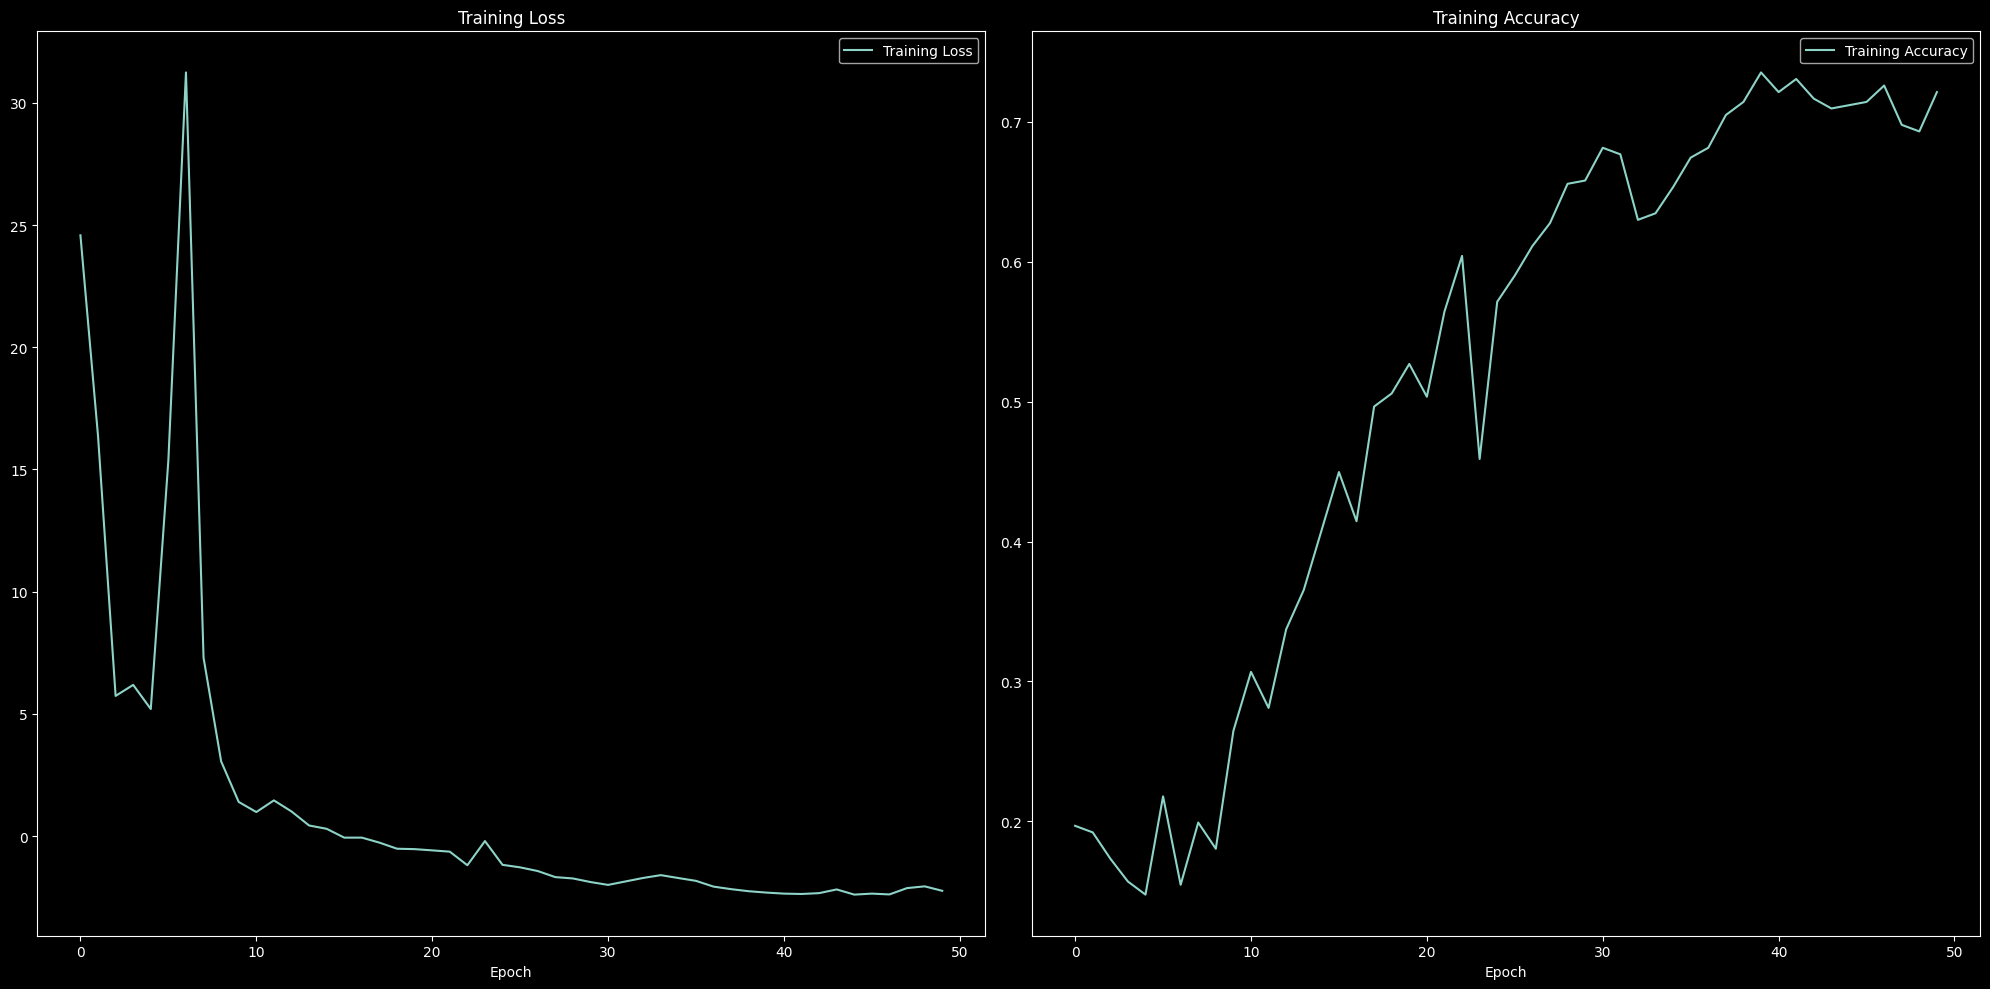

In [75]:
plt.style.use('dark_background')

# Plot loss and accuracy graphs
plt.figure(figsize=(20, 10))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [76]:
y_p = model.predict(X_test)

1/1 [==============================] - 1s 1s/step


In [77]:
y_p.shape

(23, 6)

In [78]:
y_test.shape

(23, 6)

In [79]:
# def calculate_reward(y_true, y_pred):
#     # Correct Predictions
#     correct_predictions = np.sum(y_true * y_pred)

#     # Diversity Penalty
#     mean_pred_axis_0 = np.mean(y_pred, axis=0)
#     mean_pred_axis_1 = np.mean(y_pred, axis=1).reshape(-1, 1)  # Reshape to (19, 1)
#     diversity_penalty = np.linalg.norm(mean_pred_axis_0 - mean_pred_axis_1, ord=2)
#     diversity_penalty = np.linalg.norm(mean_pred_axis_0 - mean_pred_axis_1, ord=2)

#     # Weighted Mistakes Penalty
#     weighted_mistakes_penalty = np.sum(np.square(y_true - y_pred) * np.array([1.0, 2.0, 1.5, 1.0, 2.0, 1.5]))

#     # External Metric Bonus
#     external_metric_bonus = 0.2

#     # Final Reward
#     reward = correct_predictions - 0.1 * diversity_penalty - 0.5 * weighted_mistakes_penalty + external_metric_bonus

#     return reward

In [80]:
# calculate_reward(y_test,y_p)

In [81]:
res = model.predict(X_test)

1/1 [==============================] - 0s 133ms/step


In [82]:
X_test

array([[[ 0.59871942,  0.37086555, -0.48753017, ...,  0.60805535,
          0.47055244, -0.01673608],
        [ 0.59567672,  0.35899293, -0.49486771, ...,  0.61074209,
          0.46940532, -0.01632933],
        [ 0.59192789,  0.35368776, -0.49347323, ...,  0.60755074,
          0.47368744, -0.01455485],
        ...,
        [ 0.60172969,  0.35736856, -0.68807209, ...,  0.60885763,
          0.46942204, -0.01480539],
        [ 0.59967166,  0.35454938, -0.68387043, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.59897631,  0.35407767, -0.62372226, ...,  0.61369723,
          0.47550216, -0.0139253 ]],

       [[ 0.52524602,  0.54641026, -1.26102698, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.52491498,  0.5465275 , -1.28690398, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.52056628,  0.54661125, -1.33708084, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.50423199,  0.55809498, -1.69546616, ...,  

In [83]:
res

array([[2.95638125e-10, 1.00000000e+00, 1.80061967e-15, 9.83689325e-16,
        1.41745685e-10, 1.13799005e-10],
       [1.41439036e-01, 2.91506052e-01, 4.74389613e-01, 3.80867685e-04,
        8.91095251e-02, 3.17486911e-03],
       [1.05340928e-01, 2.84366757e-01, 4.02615100e-01, 9.29064490e-03,
        1.97412953e-01, 9.73568764e-04],
       [1.93616953e-02, 2.01186383e-04, 6.80278465e-02, 9.01098311e-01,
        1.12879565e-02, 2.30252426e-05],
       [2.05168567e-06, 9.99996781e-01, 3.05397027e-11, 7.60293772e-11,
        1.08007816e-06, 6.09422131e-08],
       [1.24948809e-03, 8.21503399e-09, 2.23116440e-04, 9.98351574e-01,
        1.75884139e-04, 4.06901002e-09],
       [4.40514064e-04, 1.60144176e-02, 1.03102820e-02, 3.11240058e-07,
        1.48764916e-03, 9.71746922e-01],
       [7.85612792e-05, 8.18117242e-03, 7.93525949e-02, 6.83191672e-07,
        4.55884408e-04, 9.11931098e-01],
       [9.99375045e-01, 6.00782914e-06, 1.67612907e-05, 4.45382587e-15,
        6.01709296e-04, 

In [84]:
actions[np.argmax(res[4])]

'fear'

In [85]:
actions[np.argmax(y_test[4])]

'fear'

In [89]:
model.save('action_with_Reward_4_v2.h5')
model.save_weights('action_with_Reward_4_weights_v2.h5')

H:\PYTHON\PYTHON SYSTEM FILES\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [87]:
import tensorflow as tf

In [124]:
model = tf.keras.models.load_model("action_with_Reward_4_v2.h5", custom_objects={'custom_loss_with_reward': custom_loss_with_reward})

In [173]:
_, test1, _, test1_label = train_test_split(X, y, test_size=0.30)

In [174]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [175]:
yhat = model.predict(test1)

5/5 [==============================] - 1s 117ms/step


In [176]:
ytrue = np.argmax(test1_label, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [177]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[110,   1],
        [  3,  21]],

       [[103,  10],
        [  4,  18]],

       [[107,   6],
        [  2,  20]],

       [[115,   2],
        [  5,  13]],

       [[113,   4],
        [  8,  10]],

       [[ 97,   7],
        [  8,  23]]], dtype=int64)

In [178]:
accuracy_score(ytrue, yhat)

0.7777777777777778

In [179]:
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
print(classification_report(ytrue,yhat))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91        24
           1       0.64      0.82      0.72        22
           2       0.77      0.91      0.83        22
           3       0.87      0.72      0.79        18
           4       0.71      0.56      0.63        18
           5       0.77      0.74      0.75        31

    accuracy                           0.78       135
   macro avg       0.79      0.77      0.77       135
weighted avg       0.79      0.78      0.78       135



In [84]:
for num, prob in enumerate(res):
    print(num,prob)

0 [3.6521940e-04 2.0128448e-07 3.3718400e-10 9.9963391e-01 6.1227837e-07
 5.0661747e-10]
1 [3.4301538e-06 4.6805860e-03 2.5875620e-06 1.4723848e-07 3.0718977e-04
 9.9500602e-01]
2 [7.2013503e-03 6.9841933e-01 1.0202408e-07 1.9921022e-06 2.9432565e-01
 5.1498799e-05]
3 [4.2127284e-11 2.8666599e-07 9.9896109e-01 2.0460072e-07 4.3546397e-06
 1.0340874e-03]
4 [9.4844267e-04 3.6442715e-01 1.5633635e-04 5.8701600e-05 6.1561775e-01
 1.8791644e-02]
5 [3.3096637e-04 6.5419748e-08 1.4106234e-10 9.9966884e-01 1.6104258e-07
 2.4377617e-10]
6 [5.6023855e-04 8.1833499e-03 6.1532844e-02 1.3720146e-02 8.9244479e-01
 2.3558564e-02]
7 [5.2795900e-11 2.4361842e-07 9.9928063e-01 7.5687905e-07 1.1050457e-05
 7.0741476e-04]
8 [1.7556411e-07 1.6417147e-03 1.5787147e-05 4.3971426e-08 9.5502503e-05
 9.9824679e-01]
9 [9.6483475e-01 2.7724900e-05 6.2341087e-06 3.5124000e-02 1.2687084e-06
 6.1135943e-06]
10 [6.2224818e-03 4.5542541e-01 3.0142110e-07 4.8135407e-05 5.3830093e-01
 2.7321169e-06]
11 [2.7401868e-06 9.

In [17]:
from scipy import stats

In [18]:
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245), (255, 0, 0), (0, 255, 0), (0, 0, 255)]

def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        probability_text = f"{prob * 100:.4f}"  # Format probability to display up to 4 decimal points
        label_text = actions[num]
        cv2.putText(output_frame, f"{label_text}: {probability_text}", (0, 85 + num * 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    return output_frame

In [87]:
# prob_viz(res[0], actions, image, colors)

In [63]:
# plt.figure(figsize=(18,18))
# plt.imshow(prob_viz(res[2], actions, image, colors))

In [64]:
import tensorflow as tf

In [13]:
model = tf.keras.models.load_model("action_with_Reward_4.h5", custom_objects={'custom_loss_with_reward': custom_loss_with_reward})

In [89]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture("../happy19.mp4")
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        if not ret or frame is None:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(res)
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        # cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        # cv2.putText(image, ' '.join(sentence), (3,30), 
        #                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

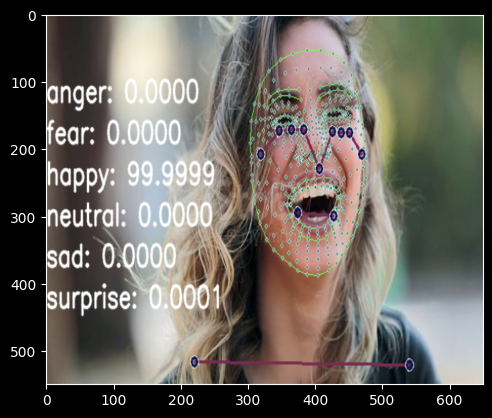

In [90]:
resized_image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (650, 550))
plt.imshow(resized_image)
plt.show()

In [91]:
# history

In [92]:
res

array([4.5295113e-17, 1.9762592e-09, 9.9999881e-01, 9.5666886e-17,
       3.8001581e-17, 1.1794162e-06], dtype=float32)

In [93]:
emo=['happy','sad','anger','surprise','fear','neutral']
emo.sort()
res
for i in range(len(actions)):
    print(emo[i],"---->",res[i])

anger ----> 4.5295113e-17
fear ----> 1.9762592e-09
happy ----> 0.9999988
neutral ----> 9.5666886e-17
sad ----> 3.800158e-17
surprise ----> 1.1794162e-06


In [94]:
import numpy as np


# Get the indices of the top 3 elements
top_indices = np.argsort(res)[-2:][::-1]

print("Indices of the top 3 elements:", top_indices)

Indices of the top 3 elements: [2 5]


In [95]:
ans=[]

In [96]:
for i in top_indices:
    ans.append(actions[i])

In [97]:
ans

['happy', 'surprise']

In [99]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture("J:/AUTISM DETECTION PROJECT/3DCNN/videos/sad/sad30.mp4")
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        if not ret or frame is None:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(res)
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        # cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        # cv2.putText(image, ' '.join(sentence), (3,30), 
                       # cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [100]:
res

array([6.6633277e-07, 6.3109577e-01, 1.2325951e-09, 4.3084847e-06,
       3.1587774e-01, 5.3021513e-02], dtype=float32)

In [101]:
emo=['happy','sad','anger','surprise','fear','neutral']
emo.sort()
res
for i in range(len(actions)):
    print(emo[i],"---->",res[i])

anger ----> 6.6633277e-07
fear ----> 0.63109577
happy ----> 1.2325951e-09
neutral ----> 4.3084847e-06
sad ----> 0.31587774
surprise ----> 0.053021513


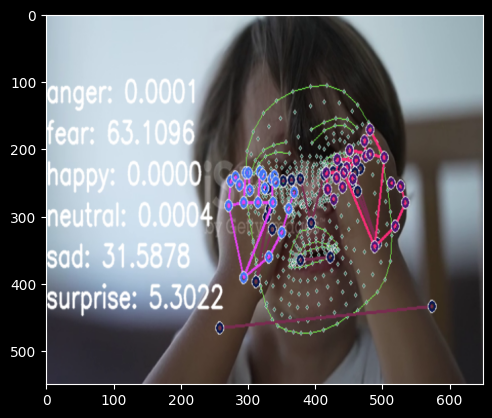

In [102]:
resized_image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (650, 550))
plt.imshow(resized_image)
plt.show()

In [103]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

actions=['happy','sad','anger','surprise','fear','neutral']
actions.sort()

cap = cv2.VideoCapture("../fear20.mp4")
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        if not ret or frame is None:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(res)
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            image = prob_viz(res, actions, image, colors)
            
        # cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        # cv2.putText(image, ' '.join(sentence), (3,30), 
        #                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        cv2.imshow('Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [104]:
res

array([4.2894894e-07, 6.5954864e-01, 6.4920373e-02, 8.3635321e-05,
       9.6607855e-06, 2.7543718e-01], dtype=float32)

In [105]:
for i in range(len(actions)):
    print(actions[i],"---->",float(res[i]))

anger ----> 4.2894893681477697e-07
fear ----> 0.6595486402511597
happy ----> 0.06492037326097488
neutral ----> 8.363532106159255e-05
sad ----> 9.660785508458503e-06
surprise ----> 0.2754371762275696


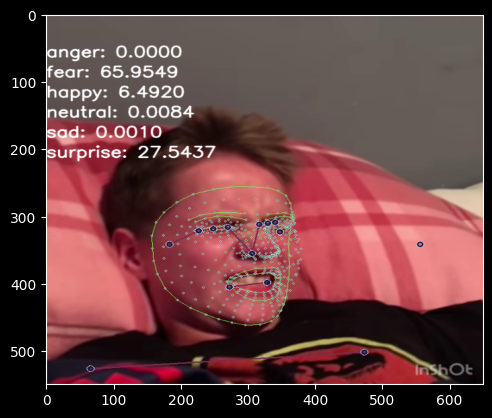

In [106]:
resized_image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (650, 550))
plt.imshow(resized_image)
plt.show()

In [23]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture("J:/AUTISM DETECTION PROJECT/Body movement data/headbanging-20230830T060850Z-001/headbanging/HB18.mp4")
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        if not ret or frame is None:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(res)
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        # cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        # cv2.putText(image, ' '.join(sentence), (3,30), 
        #                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti